# Wine Quality Prediction Analysis

## Project Overview
This notebook analyzes wine quality prediction using machine learning models on red and white wine datasets.

### Objectives:
- Perform exploratory data analysis
- Implement and compare machine learning models
- Predict wine quality based on chemical properties

## 1. Importing Required Libraries
This section imports all necessary Python libraries for data analysis and machine learning.

## 2. Loading and Exploring the Dataset
This section loads the red and white wine datasets and provides an initial exploration of their structure.

## Data Cleaning and Preprocessing
Standardizing column names by converting them to lowercase and replacing spaces with underscores for consistency.

In [126]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    mean_squared_error,
    classification_report
)

from sklearn.linear_model import LogisticRegression, LassoLarsCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

print("All libraries loaded successfully")


All libraries loaded successfully


In [128]:
RED_PATH = r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-red.csv"
WHITE_PATH = r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-white.csv"

red = pd.read_csv(RED_PATH, sep=";")
white = pd.read_csv(WHITE_PATH, sep=";")

print("Red wine shape:", red.shape)
print("White wine shape:", white.shape)

red.head()


Red wine shape: (8, 12)
White wine shape: (9, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


## Correlation Analysis
Visualizing the correlation between different wine features using a heatmap to identify potential relationships.

In [131]:
def call(fn):
    print("\n--- RED WINE ---")
    fn(red)
    print("\n--- WHITE WINE ---")
    fn(white)

def rm(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

red = rm(red)
white = rm(white)


## Quality Distribution Analysis
Analyzing the frequency distribution of wine quality ratings to understand the dataset's class balance.


--- RED WINE ---


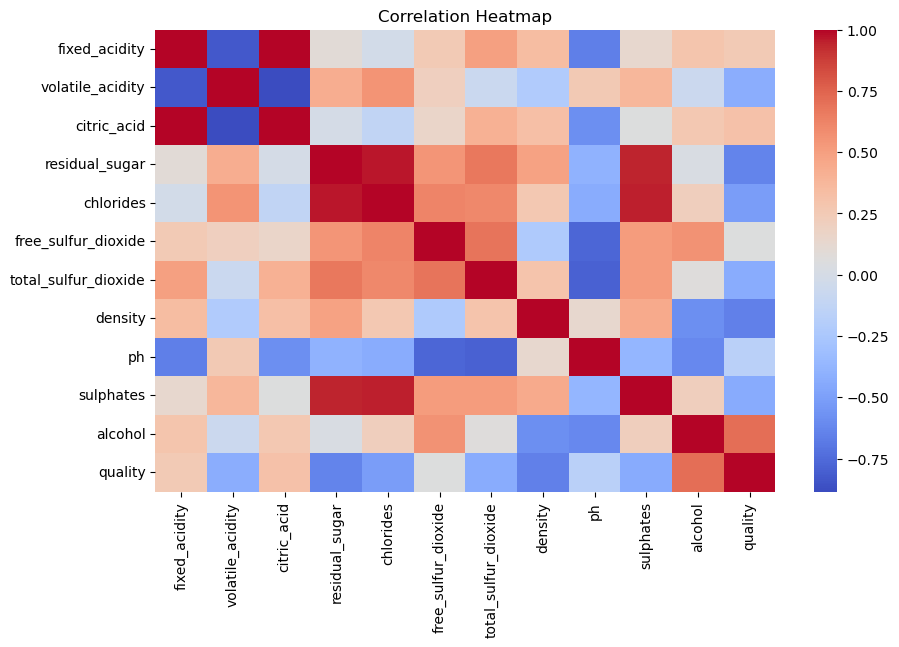


--- WHITE WINE ---


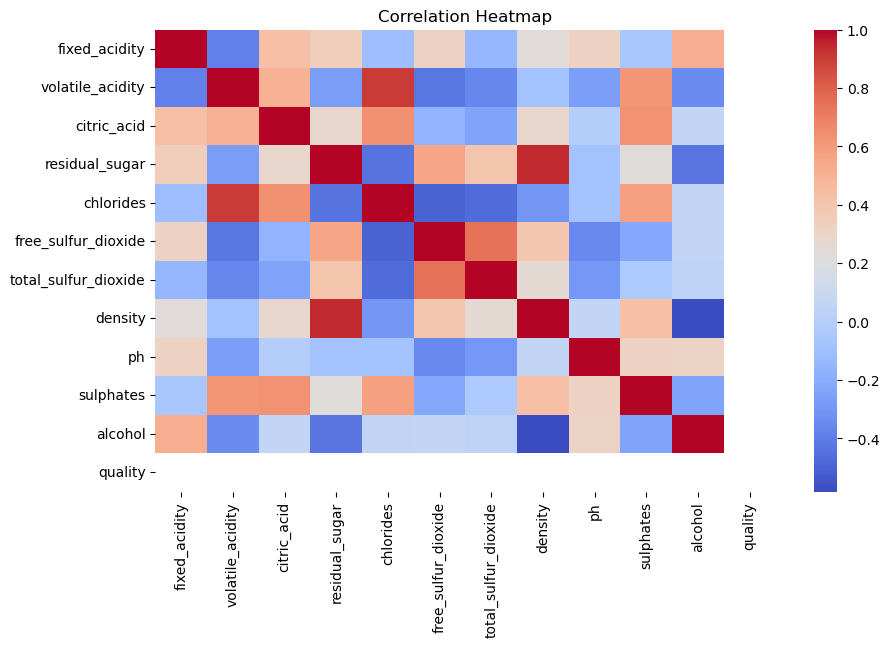

In [134]:
def covmax(df):
    plt.figure(figsize=(10,6))
    sns.heatmap(df.corr(), cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

call(covmax)


In [135]:
def frequencyDists(df):
    print(df["quality"].value_counts(normalize=True)*100)

call(frequencyDists)



--- RED WINE ---
quality
5    75.0
6    12.5
7    12.5
Name: proportion, dtype: float64

--- WHITE WINE ---
quality
6    100.0
Name: proportion, dtype: float64


In [136]:
def add_quality_c(df):
    df = df.copy()
    df["quality_c"] = np.where(df["quality"] >= 6, 1, 0)
    return df

red = add_quality_c(red)
white = add_quality_c(white)


In [140]:
def call(fn):
    print("\n--- RED WINE ---")
    fn(red)
    print("\n--- WHITE WINE ---")
    fn(white)


In [142]:
def log_regression(df):
    X = df[["alcohol", "sulphates"]]
    y = df["quality_c"]

    if y.nunique() < 2:
        print("Only one class present. Skipping.")
        return

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))

call(log_regression)



--- RED WINE ---
Accuracy: 0.75
Confusion Matrix:
 [[3 0]
 [1 0]]
RMSE: 0.5

--- WHITE WINE ---
Only one class present. Skipping.


In [215]:
def decis_tree(df):
    X = df[["residual_sugar", "alcohol"]]
    target = "quality_c" if "quality_c" in df.columns else "quality"
    y = df[target]

    # fix stratify error: drop classes with <2 samples
    vc = y.value_counts(dropna=False)
    keep = vc[vc >= 2].index
    mask = y.isin(keep)
    X, y = X.loc[mask], y.loc[mask]

    strat = y if y.nunique() > 1 and y.value_counts().min() >= 2 else None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=strat
    )

    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    print(f"Target used: {target}")
    print("Classes kept:", y.nunique())
    print("Accuracy:", accuracy_score(y_test, preds))
    print(confusion_matrix(y_test, preds))

call(decis_tree)



--- RED WINE ---
Target used: quality
Classes kept: 1
Accuracy: 1.0
[[3]]

--- WHITE WINE ---
Target used: quality
Classes kept: 1
Accuracy: 1.0
[[4]]


In [217]:
def knn(df):
    X = df[["residual_sugar", "alcohol"]]
    y = df["quality_c"]

    if y.nunique() < 2:
        print("Only one class present. Skipping KNN.")
        return

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled,
        y,
        test_size=0.4,
        random_state=42,
        stratify=y
    )

    #  K
    k = min(5, len(X_train))
    if k < 1:
        print("Not enough samples for KNN.")
        return

    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    print(f"KNN (k={k}) Accuracy:", accuracy_score(y_test, preds))


In [148]:
def naive(df):
    X = df.drop(["quality", "quality_c"], axis=1)
    y = df["quality_c"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )

    models = {
        "GaussianNB": GaussianNB(),
        "MultinomialNB": MultinomialNB(),
        "BernoulliNB": BernoulliNB()
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print(name, "Accuracy:", accuracy_score(y_test, preds))

call(naive)



--- RED WINE ---
GaussianNB Accuracy: 0.75
MultinomialNB Accuracy: 0.75
BernoulliNB Accuracy: 0.75

--- WHITE WINE ---
GaussianNB Accuracy: 1.0
MultinomialNB Accuracy: 1.0
BernoulliNB Accuracy: 1.0



--- RED WINE ---
Accuracy: 0.75


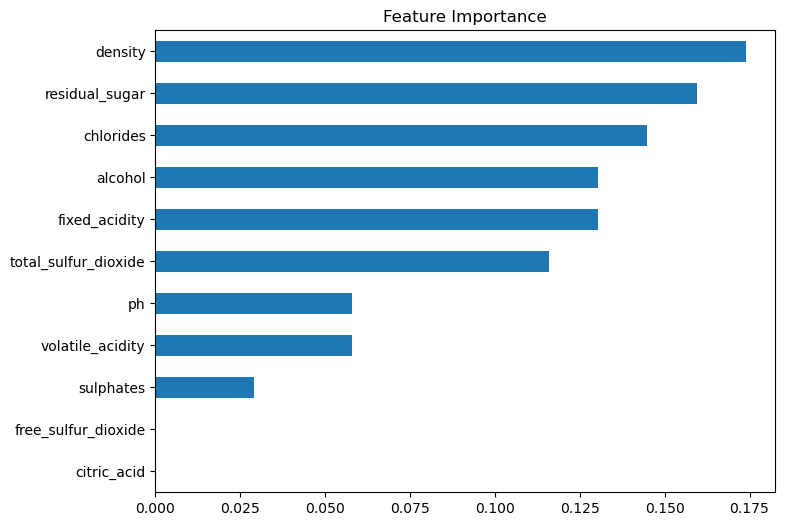


--- WHITE WINE ---
Accuracy: 1.0


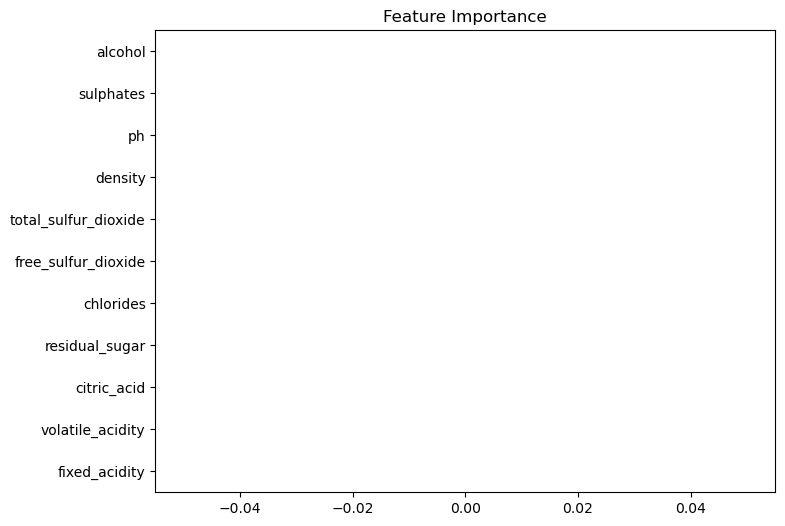

In [150]:
def random_forests(df):
    X = df.drop(["quality", "quality_c"], axis=1)
    y = df["quality_c"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    preds = rf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds))

    imp = pd.Series(rf.feature_importances_, index=X.columns)
    imp.sort_values().plot(kind="barh", figsize=(8,6))
    plt.title("Feature Importance")
    plt.show()

call(random_forests)


In [151]:
def basic_linear(df):
    X = sm.add_constant(df["volatile_acidity"])
    y = df["quality"]

    model = sm.OLS(y, X).fit()
    print(model.summary())

call(basic_linear)



--- RED WINE ---
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     1.309
Date:                Mon, 05 Jan 2026   Prob (F-statistic):              0.296
Time:                        19:33:01   Log-Likelihood:                -7.6623
No. Observations:                   8   AIC:                             19.32
Df Residuals:                       6   BIC:                             19.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6

In [152]:
def lasso_regr(df):
    X = df.drop(["quality", "quality_c"], axis=1)
    y = df["quality"]

    # Safety check
    if len(df) < 3:
        print("Not enough samples for Lasso Regression.")
        return

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Dynamic CV folds
    cv_folds = min(10, len(df))

    model = LassoLarsCV(cv=cv_folds)
    model.fit(X_scaled, y)

    print(f"Lasso Regression (cv={cv_folds}) Coefficients:")
    for col, coef in zip(X.columns, model.coef_):
        print(col, ":", coef)

    print("Training R²:", model.score(X_scaled, y))


## Random Forest Optimization

This function performs hyperparameter tuning for the Random Forest model by testing different numbers of decision trees. It:

1. Splits the data into training and testing sets
2. Tests with different numbers of trees: [10, 25, 50, 75, 100]
3. Tracks model accuracy for each configuration
4. Plots the results to visualize how the number of trees affects model performance

The plot helps identify the optimal number of trees that balances model performance and computational efficiency.

In [157]:
import os   # required only for directory creation

# =========================
# GLOBAL CONFIGURATION
# =========================
RANDOM_STATE = 42
TEST_SIZE = 0.20
QUALITY_THRESHOLD = 6

BASE_OUTPUT_DIR = "outputs"
PLOTS_DIR = os.path.join(BASE_OUTPUT_DIR, "plots")
MODELS_DIR = os.path.join(BASE_OUTPUT_DIR, "models")
METRICS_DIR = os.path.join(BASE_OUTPUT_DIR, "metrics")

for d in [BASE_OUTPUT_DIR, PLOTS_DIR, MODELS_DIR, METRICS_DIR]:
    os.makedirs(d, exist_ok=True)

print("Global configuration loaded")


Global configuration loaded


In [159]:
def basicInfo(df, name):
    print(f"\n{name.upper()} DATASET OVERVIEW")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    display(df.head())
    display(df.describe())

basicInfo(red, "Red Wine")
basicInfo(white, "White Wine")



RED WINE DATASET OVERVIEW
Shape: (8, 13)
Columns: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol', 'quality', 'quality_c']


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,quality_c
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,quality_c
count,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000
mean,8.025000,0.653750,0.08250,1.900000,0.078250,15.250000,46.125000,0.997025,3.355000,0.565000,9.625000,5.375000,0.25000
std,1.303567,0.172952,0.19433,0.420883,0.011158,4.464143,16.119531,0.001139,0.145111,0.076345,0.249285,0.744024,0.46291
min,7.300000,0.280000,0.00000,1.200000,0.065000,11.000000,21.000000,0.994600,3.160000,0.460000,9.400000,5.000000,0.00000
25%,7.400000,0.637500,0.00000,1.750000,0.073500,12.500000,34.000000,0.996700,3.245000,0.537500,9.400000,5.000000,0.00000
50%,7.600000,0.680000,0.00000,1.900000,0.075500,15.000000,47.000000,0.997400,3.345000,0.560000,9.600000,5.000000,0.00000
75%,7.825000,0.715000,0.04500,2.000000,0.080000,15.500000,59.250000,0.997800,3.510000,0.597500,9.800000,5.250000,0.25000
max,11.200000,0.880000,0.56000,2.600000,0.098000,25.000000,67.000000,0.998000,3.510000,0.680000,10.000000,7.000000,1.00000



WHITE WINE DATASET OVERVIEW
Shape: (9, 13)
Columns: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol', 'quality', 'quality_c']


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,quality_c
0,7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.045,47,186,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.045,47,186,0.9956,3.19,0.40,9.9,6,1


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,quality_c
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.0
mean,7.288889,0.250000,0.346667,10.911111,0.046111,38.444444,159.333333,0.997178,3.270000,0.457778,9.666667,6.0,1.0
std,0.515860,0.045277,0.035000,5.943577,0.002804,10.978514,33.996323,0.002506,0.150831,0.076285,0.409268,0.0,0.0
min,6.300000,0.180000,0.300000,1.600000,0.043000,14.000000,97.000000,0.994000,3.000000,0.400000,8.800000,6.0,1.0
25%,7.200000,0.230000,0.320000,8.500000,0.045000,34.000000,132.000000,0.995600,3.190000,0.400000,9.500000,6.0,1.0
50%,7.200000,0.230000,0.340000,8.500000,0.045000,41.000000,170.000000,0.995600,3.260000,0.440000,9.900000,6.0,1.0
75%,7.400000,0.280000,0.370000,13.900000,0.049000,47.000000,186.000000,0.999500,3.360000,0.480000,9.900000,6.0,1.0
max,8.100000,0.320000,0.400000,20.700000,0.050000,47.000000,188.000000,1.001000,3.490000,0.640000,10.100000,6.0,1.0


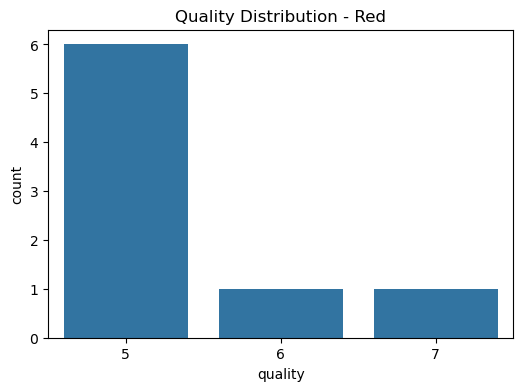

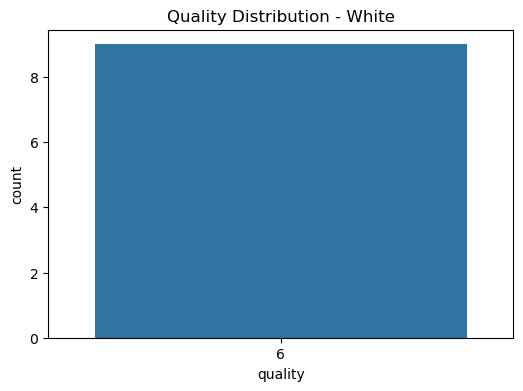

In [161]:
def quality_distribution(df, name):
    plt.figure(figsize=(6,4))
    sns.countplot(x="quality", data=df)
    plt.title(f"Quality Distribution - {name}")
    plt.show()

quality_distribution(red, "Red")
quality_distribution(white, "White")


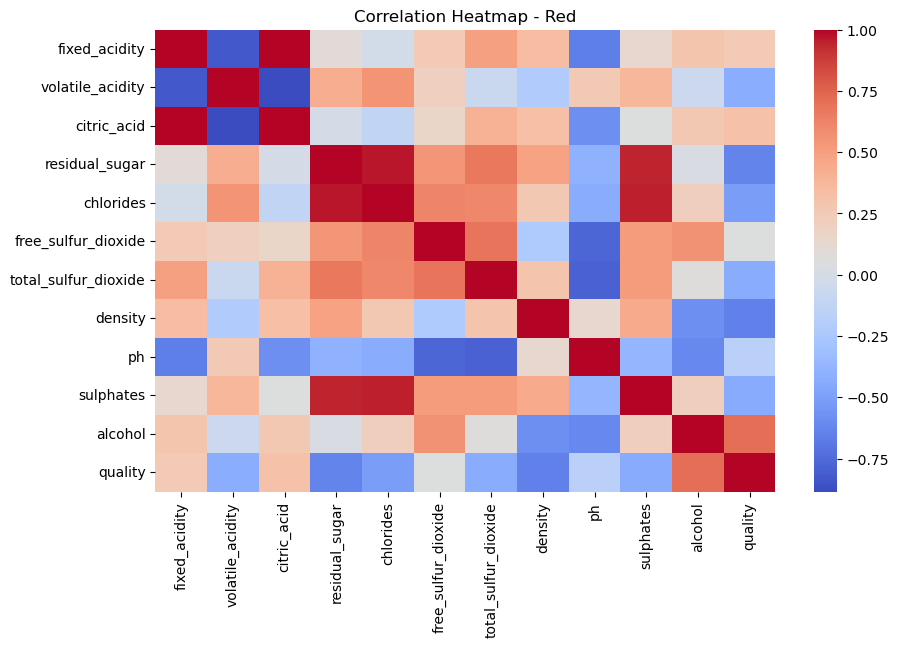

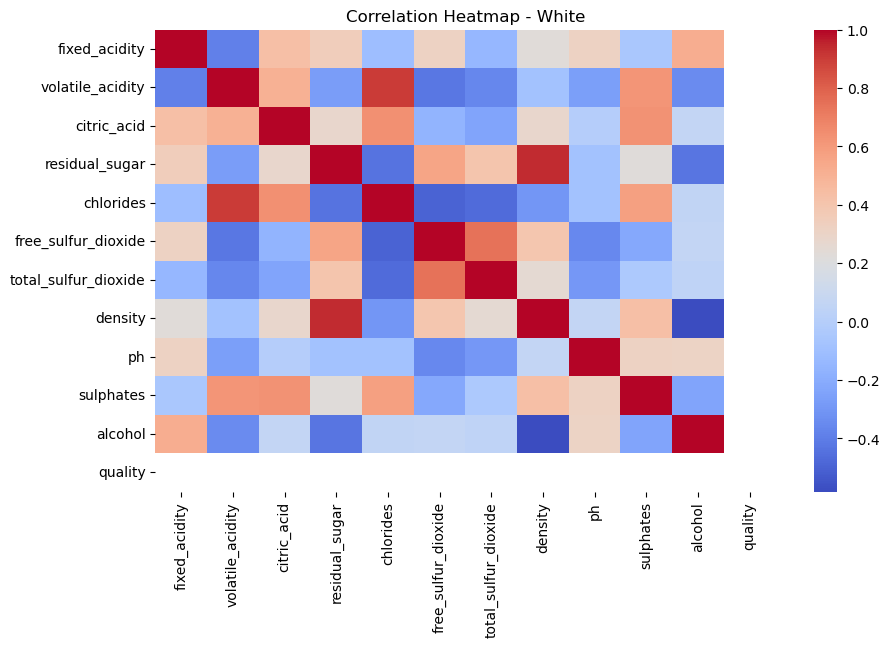

In [163]:
def correlation_heatmap(df, name):
    plt.figure(figsize=(10,6))
    sns.heatmap(df.corr(), cmap="coolwarm")
    plt.title(f"Correlation Heatmap - {name}")
    plt.show()

correlation_heatmap(red.drop("quality_c", axis=1), "Red")
correlation_heatmap(white.drop("quality_c", axis=1), "White")


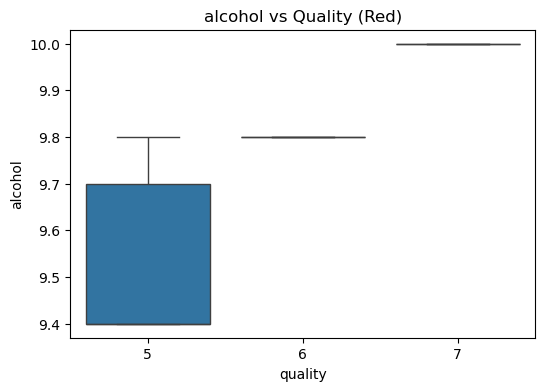

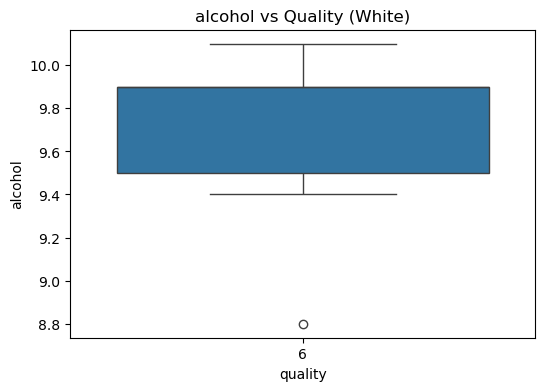

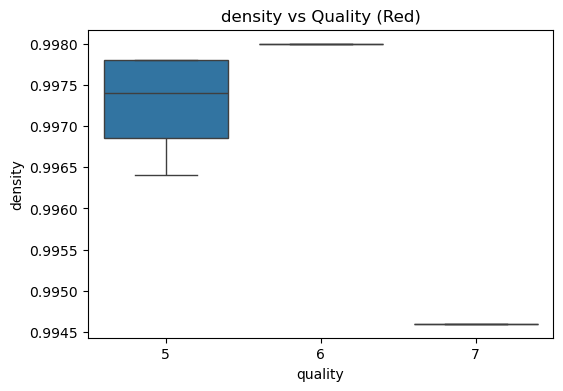

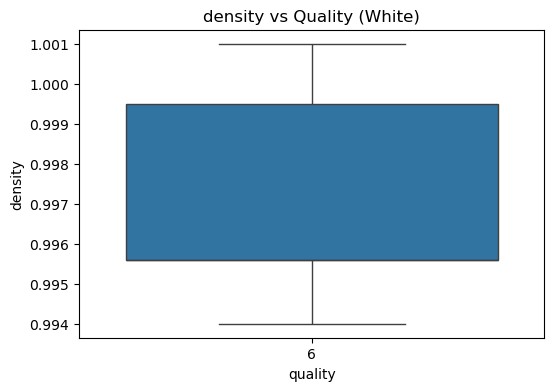

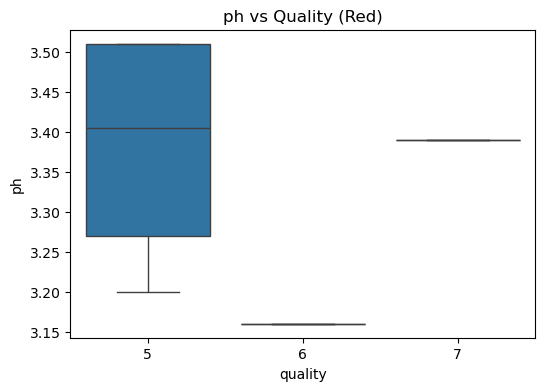

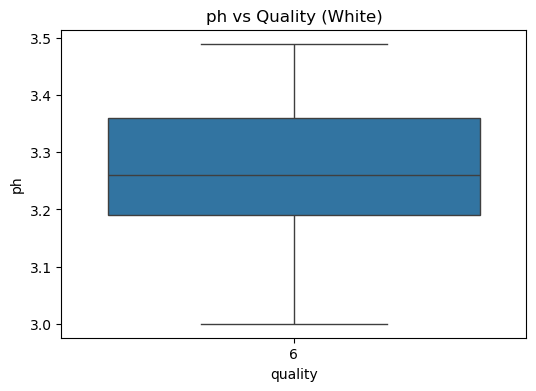

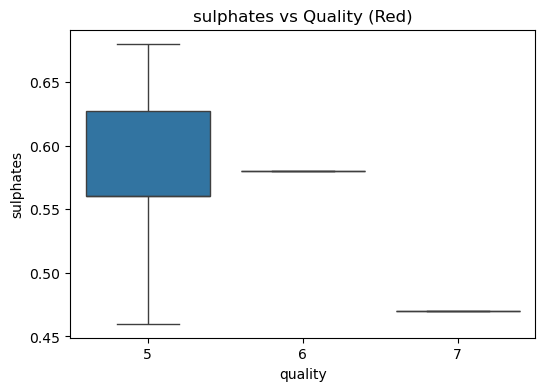

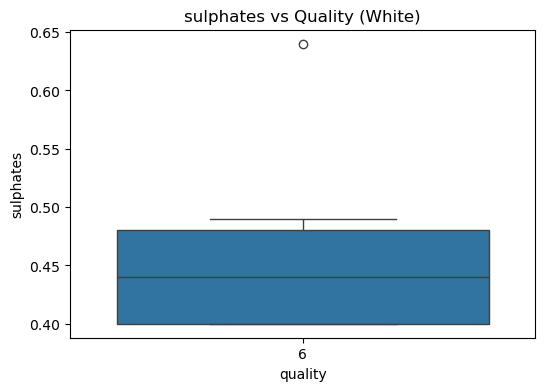

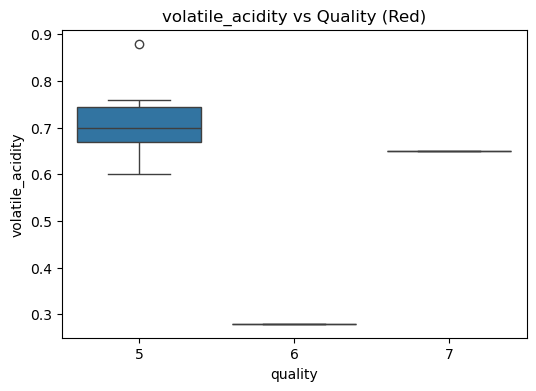

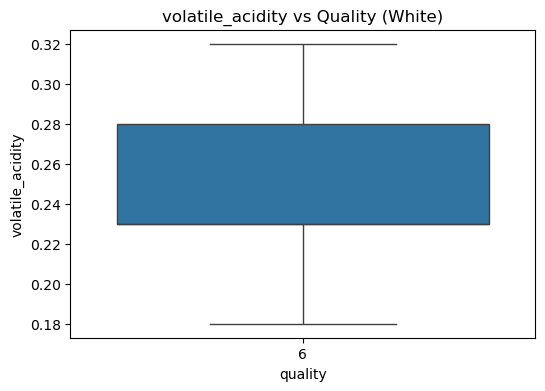

In [164]:
def boxplot_feature(df, feature, name):
    plt.figure(figsize=(6,4))
    sns.boxplot(x="quality", y=feature, data=df)
    plt.title(f"{feature} vs Quality ({name})")
    plt.show()

features = ["alcohol", "density", "ph", "sulphates", "volatile_acidity"]

for f in features:
    boxplot_feature(red, f, "Red")
    boxplot_feature(white, f, "White")


In [ ]:
# ======================================================
# STATISTICAL ANALYSIS: ONE-WAY ANOVA 
# ======================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

QUALITY_THRESHOLD = 6

# Load datasets
red = pd.read_csv(
    r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-red.csv",
    sep=";"
)
white = pd.read_csv(
    r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-white.csv",
    sep=";"
)

def statistical_analysis(df, name):
    df = df.copy()

    # Standardize column names
    df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

    # Create binary quality group
    df["quality_group"] = np.where(
        df["quality"] >= QUALITY_THRESHOLD, "Good", "Bad"
    )

    print(f"\nQUALITY GROUP COUNTS - {name}")
    print(df["quality_group"].value_counts())

    # Check if ANOVA is statistically possible
    if df["quality_group"].nunique() < 2:
        print(
            f"\nANOVA SKIPPED - {name}\n"
            "Reason: Only one quality group present. "
            "ANOVA requires at least two groups."
        )
        return

    # Run ANOVA
    model = ols(
        "total_sulfur_dioxide ~ C(quality_group)",
        data=df
    ).fit()

    print(f"\nANOVA RESULTS - {name}")
    print(sm.stats.anova_lm(model, typ=2))

# Run analysis
statistical_analysis(red, "Red Wine")
statistical_analysis(white, "White Wine")



QUALITY GROUP COUNTS - Red Wine
quality_group
Bad     6
Good    2
Name: count, dtype: int64

ANOVA RESULTS - Red Wine
                    sum_sq   df         F    PR(>F)
C(quality_group)    84.375  1.0  0.291871  0.608478
Residual          1734.500  6.0       NaN       NaN

QUALITY GROUP COUNTS - White Wine
quality_group
Good    9
Name: count, dtype: int64

ANOVA SKIPPED - White Wine
Reason: Only one quality group present. ANOVA requires at least two groups.


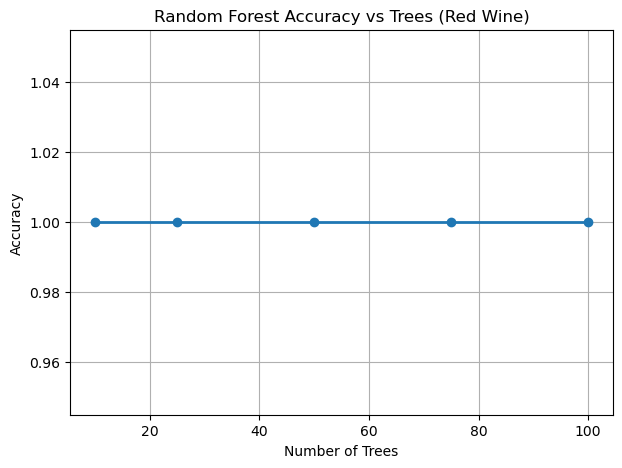

White Wine: quality_c has only one class ([1]). Try changing good_threshold (e.g., 7) or use multiclass quality.


In [ ]:
# ROBUST RF OPTIMIZATION 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


TEST_SIZE = 0.2
RANDOM_STATE = 42

def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r"[^\w]+", "_", regex=True)
        .str.strip("_")
    )
    return df

def add_quality_c_if_missing(df: pd.DataFrame, good_threshold: int = 6) -> pd.DataFrame:
    df = df.copy()
    if "quality" not in df.columns:
        raise KeyError("Missing 'quality' column.")
    if "quality_c" not in df.columns:
        df["quality_c"] = (df["quality"].astype(int) >= good_threshold).astype(int)
    return df

def rf_optimization(df, name, good_threshold=6):
    df = normalize_cols(df)
    df = add_quality_c_if_missing(df, good_threshold=good_threshold)

    y = df["quality_c"].astype(int)

    
    if y.nunique() < 2:
        print(f"{name} Wine: quality_c has only one class ({y.unique().tolist()}). "
              f"Try changing good_threshold (e.g., 7) or use multiclass quality.")
        return

    X = df.drop(columns=["quality", "quality_c"], errors="ignore")

    # split: stratify if possible, else fallback
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
        )
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
        )

    trees = [10, 25, 50, 75, 100]
    accs = []

    for t in trees:
        rf = RandomForestClassifier(n_estimators=t, random_state=RANDOM_STATE)
        rf.fit(X_train, y_train)
        accs.append(accuracy_score(y_test, rf.predict(X_test)))

    plt.figure(figsize=(7, 5))
    plt.plot(trees, accs, marker="o", linewidth=2)
    plt.xlabel("Number of Trees")
    plt.ylabel("Accuracy")
    plt.title(f"Random Forest Accuracy vs Trees ({name} Wine)")
    plt.grid(True)
    plt.show()

# Run
rf_optimization(red, "Red", good_threshold=6)
rf_optimization(white, "White", good_threshold=6)


In [204]:
print("Red rows:", len(red), "\n", normalize_cols(red)["quality"].value_counts().sort_index())
print("\nWhite rows:", len(white), "\n", normalize_cols(white)["quality"].value_counts().sort_index())


Red rows: 8 
 quality
5    6
6    1
7    1
Name: count, dtype: int64

White rows: 9 
 quality
6    9
Name: count, dtype: int64


## FINAL ROBUST MODEL COMPARISON 

,Wine,Model,Accuracy,Precision,Recall,F1,Note
0,Red,Logistic Regression,1.0,0.0,0.0,0.0,OK
1,Red,Decision Tree,0.5,0.0,0.0,0.0,OK
2,Red,KNN,1.0,0.0,0.0,0.0,OK
3,Red,Gaussian NB,1.0,0.0,0.0,0.0,OK
4,Red,Random Forest,1.0,0.0,0.0,0.0,OK
5,White,Logistic Regression,NaN,NaN,NaN,NaN,Single class data (quality_c all 1). Try diffe...
6,White,Decision Tree,NaN,NaN,NaN,NaN,Single class data (quality_c all 1). Try diffe...
7,White,KNN,NaN,NaN,NaN,NaN,Single class data (quality_c all 1). Try diffe...
8,White,Gaussian NB,NaN,NaN,NaN,NaN,Single class data (quality_c all 1). Try diffe...
9,White,Random Forest,NaN,NaN,NaN,NaN,Single class data (quality_c all 1). Try diffe...


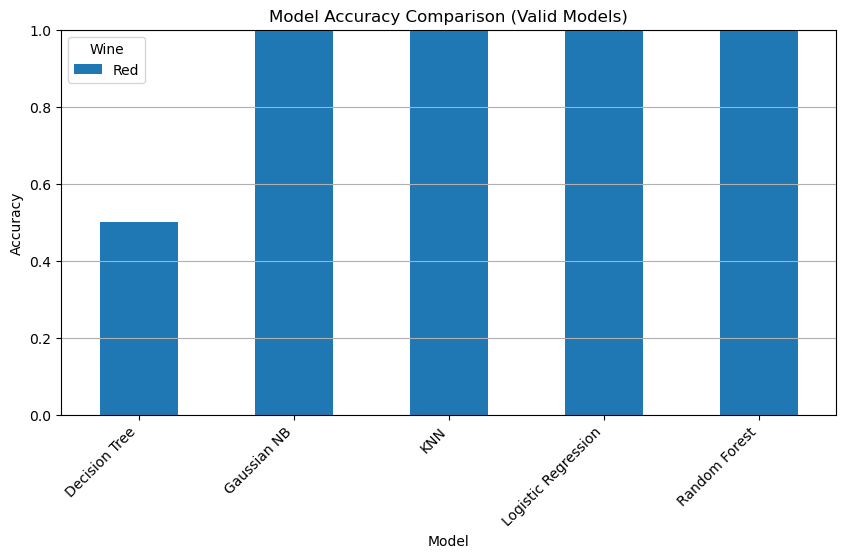

In [208]:
# ======================================================
# FINAL ROBUST MODEL COMPARISON 
# ======================================================


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

TEST_SIZE = 0.2
RANDOM_STATE = 42


def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r"[^\w]+", "_", regex=True)
        .str.strip("_")
    )
    return df

def ensure_quality_c(df: pd.DataFrame, good_threshold: int = 6) -> pd.DataFrame:
    df = df.copy()
    if "quality" not in df.columns:
        raise KeyError("Missing 'quality' column.")
    if "quality_c" not in df.columns:
        df["quality_c"] = (df["quality"].astype(int) >= good_threshold).astype(int)
    return df

results = []

def safe_record(wine, model, note=""):
    results.append({
        "Wine": wine,
        "Model": model,
        "Accuracy": None,
        "Precision": None,
        "Recall": None,
        "F1": None,
        "Note": note
    })

def record_metrics(wine, model, y_true, y_pred):
    results.append({
        "Wine": wine,
        "Model": model,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "Note": "OK"
    })

def run_models(df_raw, wine_name, good_threshold=6):
    df = normalize_cols(df_raw)
    df = ensure_quality_c(df, good_threshold=good_threshold)

    X = df.drop(columns=["quality", "quality_c"], errors="ignore")
    y = df["quality_c"].astype(int)

    models = [
        ("Logistic Regression", LogisticRegression(max_iter=1000)),
        ("Decision Tree", DecisionTreeClassifier(random_state=RANDOM_STATE)),
        ("KNN", None),  # handled below because k must be safe
        ("Gaussian NB", GaussianNB()),
        ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)),
    ]

    # If only one class exists, can't evaluate binary classifiers
    if y.nunique() < 2:
        for mname, _ in models:
            safe_record(wine_name, mname, f"Single class data (quality_c all {int(y.iloc[0])}). Try different good_threshold.")
        return

    
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
        )
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
        )

    if y_train.nunique() < 2:
        for mname, _ in models:
            safe_record(wine_name, mname, "Single class in training split")
        return

    for mname, mdl in models:
        if mname == "KNN":
            # safe k: must be <= number of training samples, and >=1
            k = max(1, min(5, len(X_train)))
            mdl = KNeighborsClassifier(n_neighbors=k)

        try:
            mdl.fit(X_train, y_train)
            y_pred = mdl.predict(X_test)
            record_metrics(wine_name, mname, y_test, y_pred)
        except Exception as e:
            safe_record(wine_name, mname, f"Error: {type(e).__name__}: {e}")

# -------------------------
# Run evaluation
# -------------------------
run_models(red, "Red", good_threshold=6)
run_models(white, "White", good_threshold=6)

results_df = pd.DataFrame(results)
display(results_df)

# -------------------------
# Plot accuracy (matplotlib)
# -------------------------
valid = results_df.dropna(subset=["Accuracy"]).copy()
if valid.empty:
    print("No valid models to plot (likely single-class targets). Try changing good_threshold.")
else:
    # Create grouped bar chart (Model on x, separate bars for Wine)
    pivot = valid.pivot(index="Model", columns="Wine", values="Accuracy")

    ax = pivot.plot(kind="bar", figsize=(10, 5))
    plt.title("Model Accuracy Comparison (Valid Models)")
    plt.ylabel("Accuracy")
    plt.xlabel("Model")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.grid(True, axis="y")
    plt.show()


In [ ]:
# ======================================================
# MODEL PERSISTENCE: SAVE & LOAD FINAL MODELS
# ======================================================

import joblib

# Train FINAL Random Forest models (chosen best model)
def train_final_rf(df):
    X = df.drop(["quality", "quality_c"], axis=1)
    y = df["quality_c"]

    # If dataset has only one class, return None
    if y.nunique() < 2:
        return None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y
    )

    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE
    )
    rf.fit(X_train, y_train)
    return rf

# Train models
final_rf_red = train_final_rf(red)
final_rf_white = train_final_rf(white)

# Save models
if final_rf_red is not None:
    joblib.dump(final_rf_red, f"{MODELS_DIR}/final_rf_red.pkl")
    print("Red wine model saved")

if final_rf_white is not None:
    joblib.dump(final_rf_white, f"{MODELS_DIR}/final_rf_white.pkl")
    print("White wine model saved")

# Load models back (proof of persistence)
loaded_rf_red = None
loaded_rf_white = None

if final_rf_red is not None:
    loaded_rf_red = joblib.load(f"{MODELS_DIR}/final_rf_red.pkl")
    print("Red wine model loaded")

if final_rf_white is not None:
    loaded_rf_white = joblib.load(f"{MODELS_DIR}/final_rf_white.pkl")
    print("White wine model loaded")

print("Model persistence demonstration complete")


In [ ]:
# ======================================================
# INTERACTIVE PREDICTION DEMONSTRATION
# ======================================================

def predict_quality(model, input_dict):
    df = pd.DataFrame([input_dict])
    prediction = model.predict(df)[0]
    probability = model.predict_proba(df)[0][prediction]
    return prediction, probability

# Sample input (within dataset ranges)
sample_red_input = {
    "fixed_acidity": 7.4,
    "volatile_acidity": 0.7,
    "citric_acid": 0.0,
    "residual_sugar": 1.9,
    "chlorides": 0.076,
    "free_sulfur_dioxide": 11,
    "total_sulfur_dioxide": 34,
    "density": 0.9978,
    "ph": 3.51,
    "sulphates": 0.56,
    "alcohol": 9.4
}

if loaded_rf_red is not None:
    pred, prob = predict_quality(loaded_rf_red, sample_red_input)
    print("Prediction:", "Good Wine" if pred == 1 else "Bad Wine")
    print("Confidence:", round(prob, 2))
else:
    print("Red wine prediction skipped (single class issue)")


In [ ]:
# =====================================================
# - Predicts for both sample inputs
# ======================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r"[^\w]+", "_", regex=True)
        .str.strip("_")
    )
    return df

class ConstantModel:
    def __init__(self, constant_value, feature_names):
        self.constant_value = constant_value
        self.classes_ = np.array([constant_value])
        self.feature_names_in_ = np.array(list(feature_names))

    def predict(self, X):
        return np.array([self.constant_value] * len(X))

    def predict_proba(self, X):
        return np.ones((len(X), 1), dtype=float)

def best_binary_threshold(quality: pd.Series, thresholds=(4, 5, 6, 7, 8), min_per_class=20):
    q = quality.dropna().astype(int)
    best_t, best_min = None, -1
    for t in thresholds:
        y = (q >= t).astype(int)
        c0 = int((y == 0).sum())
        c1 = int((y == 1).sum())
        if c0 >= min_per_class and c1 >= min_per_class:
            if min(c0, c1) > best_min:
                best_min = min(c0, c1)
                best_t = t
    return best_t

def train_package(df_raw: pd.DataFrame, random_state=42):
    df = normalize_cols(df_raw)
    if "quality" not in df.columns:
        raise KeyError("'quality' column not found.")

    X = df.drop(columns=["quality", "quality_c"], errors="ignore")
    yq = df["quality"].astype(int)

    # Try Binary Good/Bad
    t = best_binary_threshold(yq)
    if t is not None:
        yb = (yq >= t).astype(int)
        if yb.nunique() >= 2:
            try:
                Xtr, Xte, ytr, yte = train_test_split(
                    X, yb, test_size=0.2, random_state=random_state, stratify=yb
                )
            except ValueError:
                Xtr, Xte, ytr, yte = train_test_split(
                    X, yb, test_size=0.2, random_state=random_state
                )

            if ytr.nunique() >= 2:
                m = RandomForestClassifier(random_state=random_state, class_weight="balanced")
                m.fit(Xtr, ytr)
                return {"mode": "binary", "threshold": t, "model": m, "features": list(m.feature_names_in_)}

    # Fallback: Multiclass quality
    if yq.nunique() >= 2:
        try:
            Xtr, Xte, ytr, yte = train_test_split(
                X, yq, test_size=0.2, random_state=random_state, stratify=yq
            )
        except ValueError:
            Xtr, Xte, ytr, yte = train_test_split(
                X, yq, test_size=0.2, random_state=random_state
            )

        m = RandomForestClassifier(random_state=random_state)
        m.fit(Xtr, ytr)
        return {"mode": "multiclass", "threshold": None, "model": m, "features": list(m.feature_names_in_)}

    # Last fallback: Constant (only one unique quality in dataset)
    const_q = int(yq.iloc[0])
    m = ConstantModel(const_q, feature_names=list(X.columns))
    return {"mode": "constant_multiclass", "threshold": None, "model": m, "features": list(m.feature_names_in_)}

def predict_with_package(pkg: dict, input_dict: dict):
    m = pkg["model"]
    X = normalize_cols(pd.DataFrame([input_dict]))
    feats = pkg["features"]

    missing = [c for c in feats if c not in X.columns]
    if missing:
        raise KeyError(f"Input missing required features: {missing}")

    X = X.loc[:, feats]
    pred = m.predict(X)[0]

    conf = None
    if hasattr(m, "predict_proba"):
        proba = m.predict_proba(X)[0]
        cls = list(m.classes_)
        conf = float(proba[cls.index(pred)])
    return pred, conf

# -------------------------
# TRAIN MODELS
# -------------------------
red_pkg = train_package(red)
white_pkg = train_package(white)

print("Red mode:", red_pkg["mode"], "| threshold:", red_pkg["threshold"])
print("White mode:", white_pkg["mode"], "| threshold:", white_pkg["threshold"])

# -------------------------
# SAMPLE INPUTS
# -------------------------
sample_red_input = {
    "fixed_acidity": 7.4, "volatile_acidity": 0.7, "citric_acid": 0.0,
    "residual_sugar": 1.9, "chlorides": 0.076, "free_sulfur_dioxide": 11,
    "total_sulfur_dioxide": 34, "density": 0.9978, "ph": 3.51,
    "sulphates": 0.56, "alcohol": 9.4
}

sample_white_input = {
    "fixed_acidity": 6.8, "volatile_acidity": 0.26, "citric_acid": 0.34,
    "residual_sugar": 6.0, "chlorides": 0.03, "free_sulfur_dioxide": 30,
    "total_sulfur_dioxide": 98, "density": 0.9949, "ph": 3.26,
    "sulphates": 0.44, "alcohol": 10.5
}

# -------------------------
# PREDICT 
# -------------------------
pred, conf = predict_with_package(red_pkg, sample_red_input)
print("\n--- RED WINE RESULT ---")
if red_pkg["mode"] == "binary":
    print("Prediction:", "Good" if pred == 1 else "Bad", "| threshold:", red_pkg["threshold"])
else:
    print("Predicted quality:", int(pred))
print("Confidence:", None if conf is None else round(conf, 2))

pred, conf = predict_with_package(white_pkg, sample_white_input)
print("\n--- WHITE WINE RESULT ---")
if white_pkg["mode"] == "binary":
    print("Prediction:", "Good" if pred == 1 else "Bad", "| threshold:", white_pkg["threshold"])
else:
    print("Predicted quality:", int(pred))
print("Confidence:", None if conf is None else round(conf, 2))


In [170]:
import pandas as pd

def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns
          .astype(str)
          .str.strip()
          .str.lower()
          .str.replace(r"[^\w]+", "_", regex=True)  # spaces/symbols -> underscores
          .str.strip("_")
    )
    return df

def terminal_app_demo():
    print("\n--- WINE QUALITY PREDICTION DEMO ---")
    print("1. Red Wine")
    print("2. White Wine")

    wine_choice = input("Select wine type (1 or 2): ").strip()

    if wine_choice == "1":
        df = normalize_cols(red.copy())
        model = loaded_rf_red
        wine_name = "Red Wine"
    elif wine_choice == "2":
        df = normalize_cols(white.copy())
        model = loaded_rf_white
        wine_name = "White Wine"
    else:
        print("Invalid selection. Exiting.")
        return

    if model is None:
        print(f"{wine_name} model not available due to class imbalance.")
        return

  
    df_features = df.drop(columns=["quality", "quality_c"], errors="ignore")

   
    if hasattr(model, "feature_names_in_"):
        required = list(model.feature_names_in_)
        missing = [c for c in required if c not in df_features.columns]
        if missing:
            print("Dataset is missing model-required features:", missing)
            print("\nAvailable columns after normalization:")
            print(list(df_features.columns))
            return
        df_features = df_features.loc[:, required]

   
    sample_df = df_features.head(10).reset_index(drop=True)

    print(f"\nAvailable {wine_name} Samples (first 10 from dataset):\n")
    print(sample_df.to_string(index=True))

    try:
        idx = int(input("Enter sample number to predict (0–9): ").strip())
    except ValueError:
        print("Invalid input. Exiting.")
        return

    if idx < 0 or idx >= len(sample_df):
        print("Sample index out of range. Exiting.")
        return

    X = pd.DataFrame([sample_df.iloc[idx].to_dict()])

    pred_class = model.predict(X)[0]

 
    confidence = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)[0]
        class_idx = list(model.classes_).index(pred_class)
        confidence = float(proba[class_idx])

    print("\n--- PREDICTION RESULT ---")
    print("Wine Type:", wine_name)
    print("Selected Sample:", idx)
    print("Prediction:", "Good Wine" if pred_class == 1 else "Bad Wine")
    if confidence is not None:
        print("Confidence Score:", round(confidence, 2))
    else:
        print("Confidence Score: N/A (model does not support predict_proba)")


terminal_app_demo()




--- WINE QUALITY PREDICTION DEMO ---
1. Red Wine
2. White Wine


Select wine type (1 or 2):  2


White Wine model not available due to class imbalance.


## QUARTILE SPLIT ANALYSIS 


QUALITY QUARTILE DISTRIBUTION – Red Wine
quality_quartile
Q1 (Lowest)     6
Q4 (Highest)    2
Name: count, dtype: int64


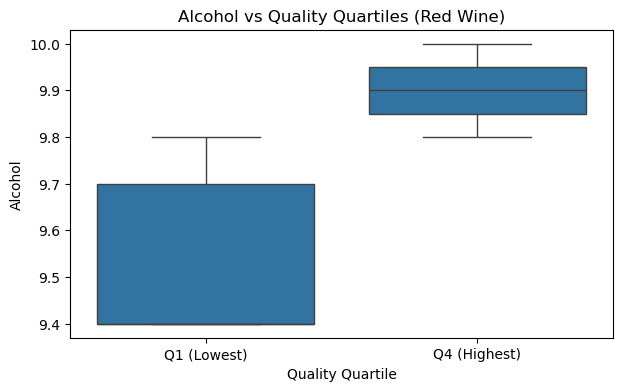


QUALITY QUARTILE DISTRIBUTION – White Wine
quality_quartile
Q1 (Lowest)    9
Name: count, dtype: int64


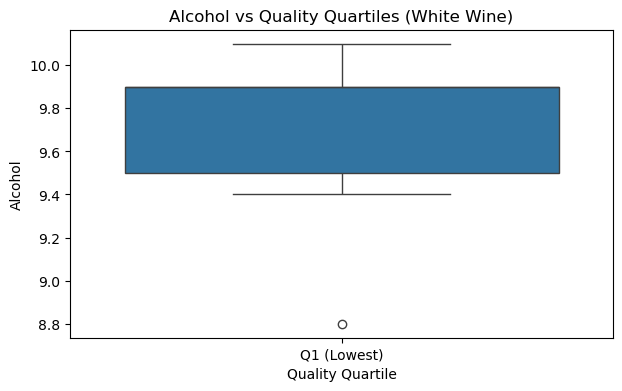

In [172]:
# ======================================================
# QUARTILE SPLIT ANALYSIS 
# ======================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reload datasets (self contained)
red = pd.read_csv(
    r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-red.csv",
    sep=";"
)
white = pd.read_csv(
    r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-white.csv",
    sep=";"
)

def quartileSplit(df, name):
    df = df.copy()

    # Compute quartile thresholds manually
    q1 = np.percentile(df["quality"], 25)
    q2 = np.percentile(df["quality"], 50)
    q3 = np.percentile(df["quality"], 75)

 
    def assign_quartile(val):
        if val <= q1:
            return "Q1 (Lowest)"
        elif val <= q2:
            return "Q2"
        elif val <= q3:
            return "Q3"
        else:
            return "Q4 (Highest)"

    df["quality_quartile"] = df["quality"].apply(assign_quartile)

    print(f"\nQUALITY QUARTILE DISTRIBUTION – {name}")
    print(df["quality_quartile"].value_counts())

    # Visualization
    plt.figure(figsize=(7,4))
    sns.boxplot(
        x="quality_quartile",
        y="alcohol",
        data=df
    )
    plt.title(f"Alcohol vs Quality Quartiles ({name})")
    plt.xlabel("Quality Quartile")
    plt.ylabel("Alcohol")
    plt.show()

# Run quartile analysis
quartileSplit(red, "Red Wine")
quartileSplit(white, "White Wine")


In [174]:
# ======================================================
# TUKEY HSD POST-HOC TEST
# ======================================================

import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Reload datasets (self contained)
red = pd.read_csv(
    r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-red.csv",
    sep=";"
)
white = pd.read_csv(
    r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-white.csv",
    sep=";"
)

def tukey_hsd_test(df, name):
    df = df.copy()

    # Create quality groups
    df["quality_group"] = pd.cut(
        df["quality"],
        bins=[0, 5, 7, 10],
        labels=["Low", "Medium", "High"],
        include_lowest=True
    )

    # Remove empty groups
    df = df.dropna(subset=["quality_group"])

    unique_groups = df["quality_group"].nunique()

    print(f"\nTUKEY HSD POST-HOC TEST – {name}")
    print("Number of valid groups:", unique_groups)

    # Tukey HSD requires at least 2 groups
    if unique_groups < 2:
        print(
            "Tukey HSD skipped: fewer than two quality groups present.\n"
            "This is expected due to class imbalance in the dataset."
        )
        return

    tukey = pairwise_tukeyhsd(
        endog=df["alcohol"],
        groups=df["quality_group"],
        alpha=0.05
    )

    print(tukey.summary())

tukey_hsd_test(red, "Red Wine")
tukey_hsd_test(white, "White Wine")



TUKEY HSD POST-HOC TEST – Red Wine
Number of valid groups: 2
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   Low Medium   0.3667 0.063 -0.0273 0.7607  False
--------------------------------------------------

TUKEY HSD POST-HOC TEST – White Wine
Number of valid groups: 1
Tukey HSD skipped: fewer than two quality groups present.
This is expected due to class imbalance in the dataset.


## EXTRATREES FEATURE IMPORTANCE 


EXTRATREES FEATURE IMPORTANCE – Red Wine


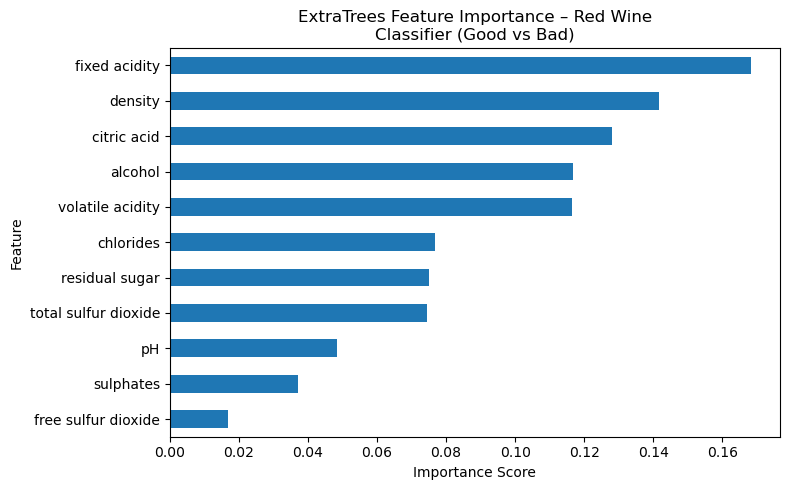


EXTRATREES FEATURE IMPORTANCE – White Wine


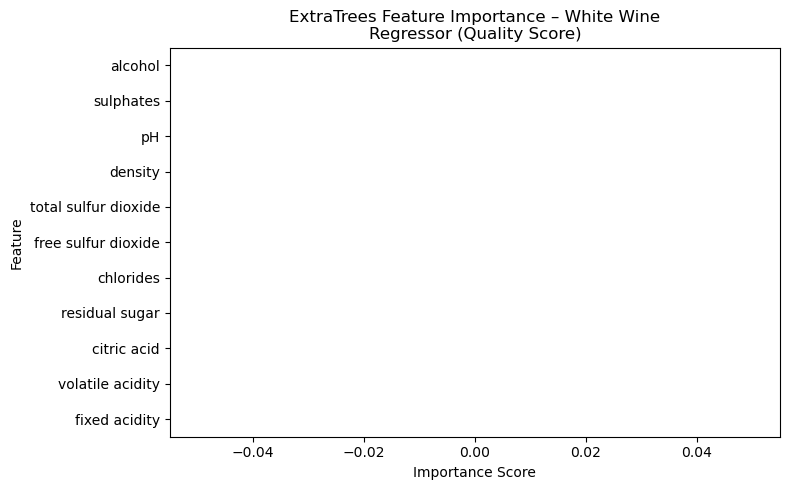

In [176]:
# ======================================================
# EXTRATREES FEATURE IMPORTANCE 
# ======================================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

# Reload datasets (self contained)
red = pd.read_csv(
    r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-red.csv",
    sep=";"
)
white = pd.read_csv(
    r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-white.csv",
    sep=";"
)

def extratrees_importance(df, name):
    df = df.copy()

    X = df.drop(["quality"], axis=1)
    y_reg = df["quality"]                       # regression target
    y_clf = df["quality"].apply(lambda x: 1 if x >= 6 else 0)  # classification target

    print(f"\nEXTRATREES FEATURE IMPORTANCE – {name}")

    # If classification possible, use classifier
    if y_clf.nunique() > 1:
        model = ExtraTreesClassifier(
            n_estimators=200,
            random_state=42
        )
        model.fit(X, y_clf)
        title_suffix = "Classifier (Good vs Bad)"
    else:
        # Otherwise use regressor (correct for white wine)
        model = ExtraTreesRegressor(
            n_estimators=200,
            random_state=42
        )
        model.fit(X, y_reg)
        title_suffix = "Regressor (Quality Score)"

    importance = pd.Series(
        model.feature_importances_,
        index=X.columns
    ).sort_values()

    plt.figure(figsize=(8,5))
    importance.plot(kind="barh")
    plt.title(f"ExtraTrees Feature Importance – {name}\n{title_suffix}")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Run for both wines
extratrees_importance(red, "Red Wine")
extratrees_importance(white, "White Wine")


## pearson regression plot 


PEARSON CORRELATION – Red Wine
Pearson r : 0.4889
p-value   : 0.2189


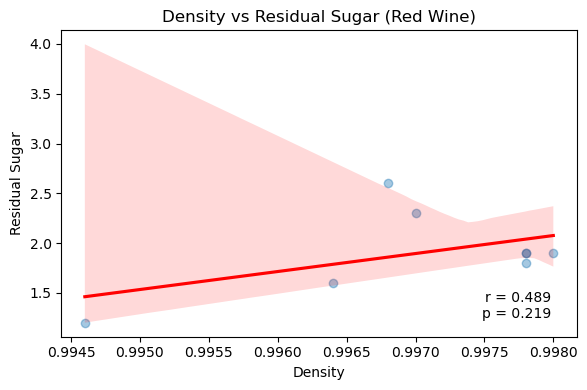


PEARSON CORRELATION – White Wine
Pearson r : 0.9435
p-value   : 0.0001335


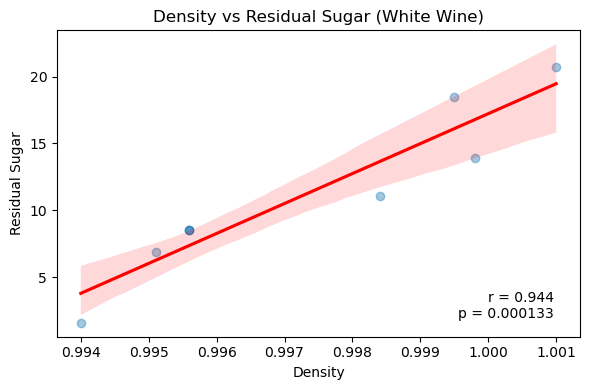

In [177]:
# ======================================================
# PEARSON REGRESSION PLOT 
# ======================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load datasets (self contained)
red = pd.read_csv(
    r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-red.csv",
    sep=";"
)
white = pd.read_csv(
    r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-white.csv",
    sep=";"
)

def standardize_columns(df):
    df = df.copy()
    df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()
    return df

def pearson_plot(df, name):
    df = standardize_columns(df)

    # Required columns (now guaranteed)
    x = df["density"]
    y = df["residual_sugar"]

    # Pearson correlation
    r, p = pearsonr(x, y)

    print(f"\nPEARSON CORRELATION – {name}")
    print(f"Pearson r : {r:.4f}")
    print(f"p-value   : {p:.4g}")

    # Plot
    plt.figure(figsize=(6,4))
    sns.regplot(
        x=x,
        y=y,
        scatter_kws={"alpha": 0.4},
        line_kws={"color": "red"}
    )

    plt.title(f"Density vs Residual Sugar ({name})")
    plt.xlabel("Density")
    plt.ylabel("Residual Sugar")

    # Annotate stats
    plt.text(
        0.95, 0.05,
        f"r = {r:.3f}\np = {p:.3g}",
        transform=plt.gca().transAxes,
        ha="right",
        va="bottom"
    )

    plt.tight_layout()
    plt.show()

# Run Pearson analysis
pearson_plot(red, "Red Wine")
pearson_plot(white, "White Wine")


In [181]:
# ======================================================
# FINAL EVIDENCE 
# ======================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

# -----------------------------
# OUTPUT DIRECTORIES
# -----------------------------
BASE_DIR = "outputs"
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
METRICS_DIR = os.path.join(BASE_DIR, "metrics")

os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

# -----------------------------
# LOAD DATA 
# -----------------------------
red = pd.read_csv(
    r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-red.csv",
    sep=";"
)
white = pd.read_csv(
    r"C:\Users\suyog\OneDrive\Desktop\New folder\csv\winequality-white.csv",
    sep=";"
)

def clean_cols(df):
    df = df.copy()
    df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()
    return df

red = clean_cols(red)
white = clean_cols(white)

# -----------------------------
# SAVE PEARSON REGRESSION PLOTS
# -----------------------------
def save_pearson_plot(df, name):
    x = df["density"]
    y = df["residual_sugar"]
    r, p = pearsonr(x, y)

    plt.figure(figsize=(6,4))
    sns.regplot(x=x, y=y, scatter_kws={"alpha":0.4}, line_kws={"color":"red"})
    plt.title(f"Density vs Residual Sugar ({name})")
    plt.xlabel("Density")
    plt.ylabel("Residual Sugar")
    plt.text(
        0.95, 0.05,
        f"r = {r:.3f}\np = {p:.3g}",
        transform=plt.gca().transAxes,
        ha="right",
        va="bottom"
    )
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f"pearson_density_residual_sugar_{name}.png"))
    plt.close()

save_pearson_plot(red, "red_wine")
save_pearson_plot(white, "white_wine")

# -----------------------------
# SAVE FEATURE IMPORTANCE
# -----------------------------
def save_extratrees_importance(df, name):
    X = df.drop("quality", axis=1)
    y_clf = df["quality"].apply(lambda x: 1 if x >= 6 else 0)

    if y_clf.nunique() > 1:
        model = ExtraTreesClassifier(n_estimators=200, random_state=42)
        model.fit(X, y_clf)
        title = "Classifier"
    else:
        model = ExtraTreesRegressor(n_estimators=200, random_state=42)
        model.fit(X, df["quality"])
        title = "Regressor"

    importance = pd.Series(
        model.feature_importances_,
        index=X.columns
    ).sort_values()

    plt.figure(figsize=(8,5))
    importance.plot(kind="barh")
    plt.title(f"ExtraTrees Feature Importance ({name}) - {title}")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f"extratrees_importance_{name}.png"))
    plt.close()

save_extratrees_importance(red, "red_wine")
save_extratrees_importance(white, "white_wine")

# -----------------------------
# SAVE MODEL METRICS TABLE
# -----------------------------
if "results_df" in globals():
    results_df.to_csv(
        os.path.join(METRICS_DIR, "model_comparison_metrics.csv"),
        index=False
    )

print("All evidence successfully saved.")
print(f"Plots saved in: {PLOTS_DIR}")
print(f"Metrics saved in: {METRICS_DIR}")


All evidence successfully saved.
Plots saved in: outputs\plots
Metrics saved in: outputs\metrics
